In [13]:
# !pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import pickle
import PIL
import math

import tensorflow as tf
import tensorflow_datasets as tfds
import codelab_utils.mpl_styles as mpl_styles
import numpy as np

from tensorflow.keras import layers, optimizers, metrics, losses, utils
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from itertools import accumulate
from functools import reduce

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [105]:
# Load Oxford-IIIT Pet Dataset
train_ds, val_ds, test_ds = tfds.load(
    'oxford_iiit_pet:3.*.*',
    split=['train[:80%]', 'train[80%:]', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

In [193]:
IMG_SIZE = 128

def preprocess(item):
    image, mask = item['image'], item['segmentation_mask']

    # Resize image and mask to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])


    # Normalize the image and realign the mask.
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    
    return image, mask

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

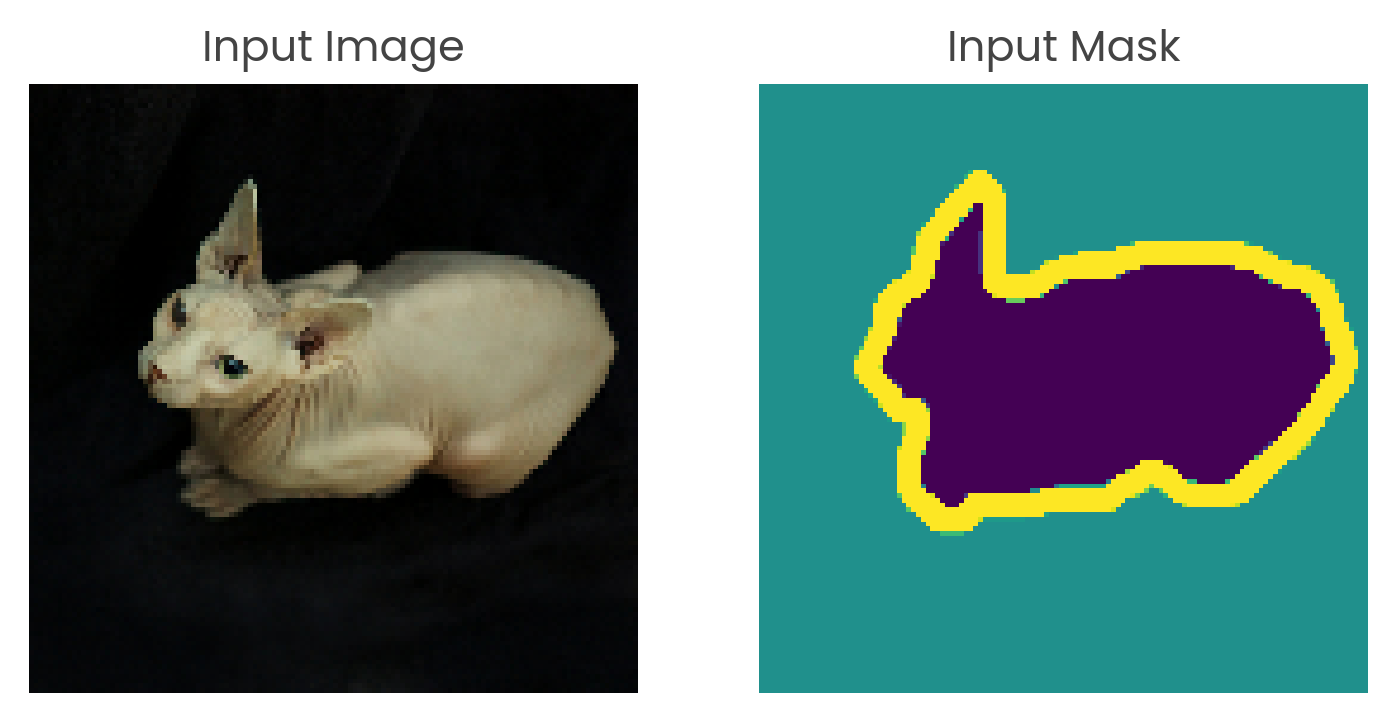

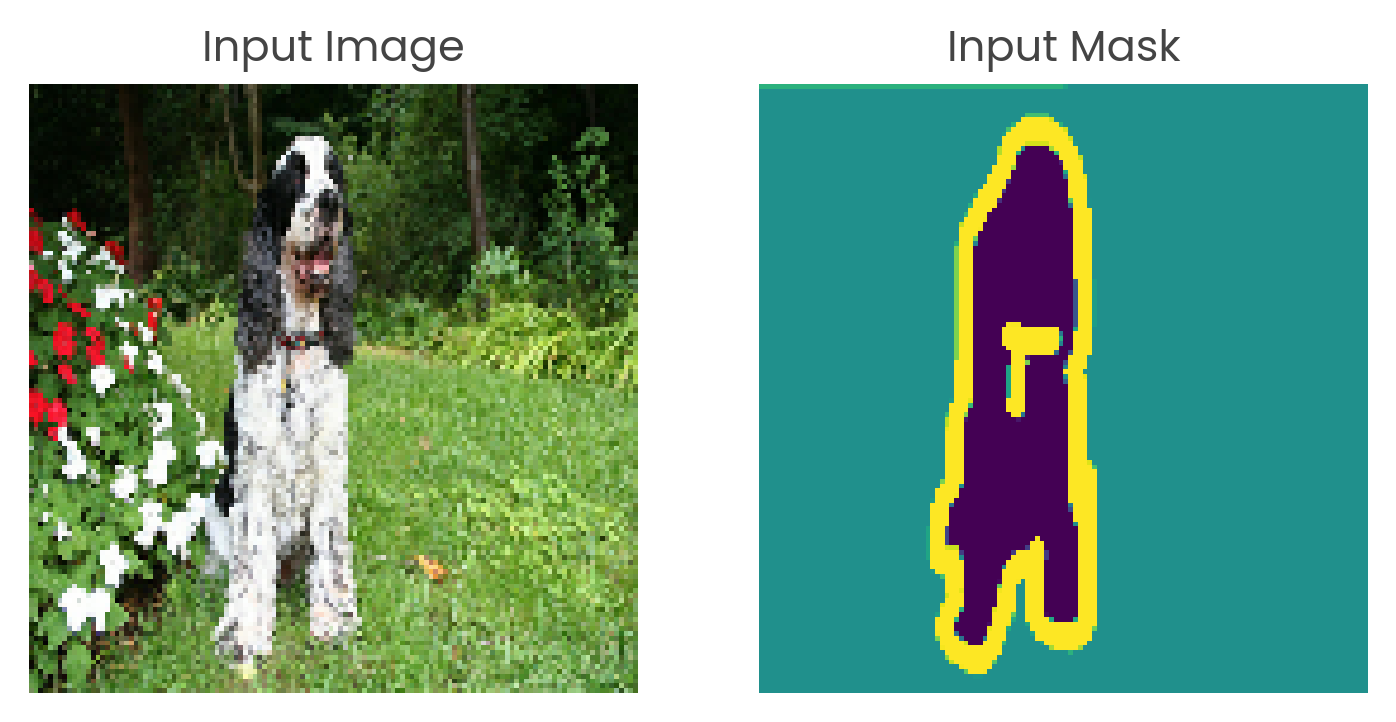

In [158]:
def plot_grid(images, cols=5):
    rows = (len(images)+cols-1)//cols
    fig, axes = plt.subplots(rows, cols)

    def axis_off(ax):
        ax.set_axis_off()
        return ax

    raveled_axes = list(map(axis_off, axes.ravel()))

    for index, name in enumerate(images):
        ax = raveled_axes[index]
        image = images[name]
        ax.imshow(image) if len(
            image.shape) == 3 else ax.imshow(image, cmap='gray')
        ax.set_title(name)


for image, mask in train_prep_ds.take(2):
    sample = {'Input Image': image, 'Input Mask': mask}
    plot_grid(sample, cols=2)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_88 (Conv2D)             (None, 126, 126, 64  1792        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_89 (Conv2D)             (None, 124, 124, 64  36928       ['conv2d_88[0][0]']              
                                )                                                           

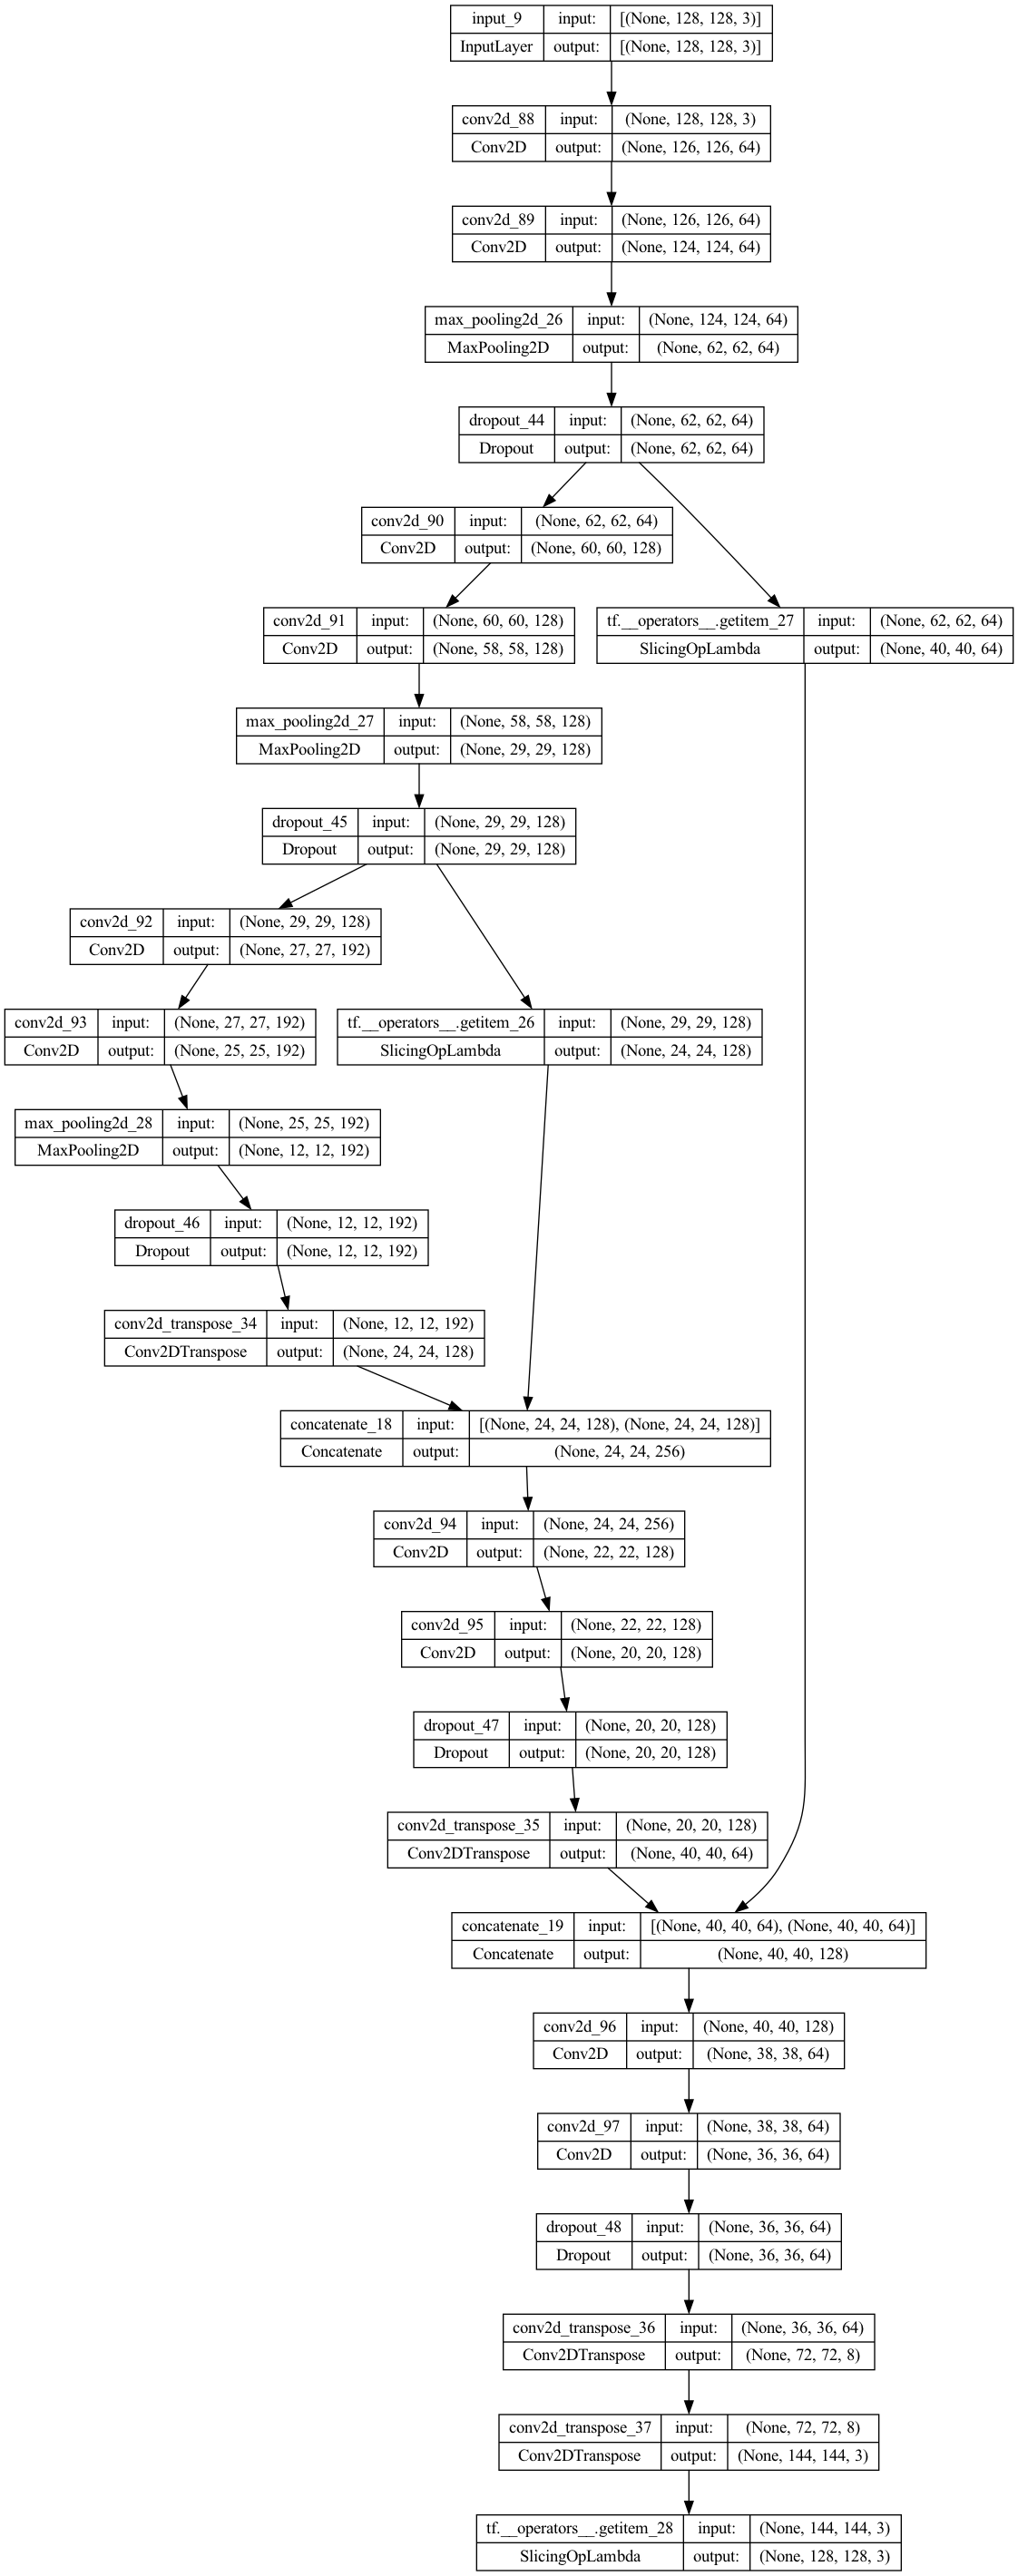

In [130]:
INITIAL_WIDTH = 64
N_ENCODERS = 2
N_CLASSES = 3
# DEBUG = True
DEBUG = False
LEARNING_RATE = 0.001
STEPS_PER_EPOCH = 184
DROPOUT_RATE = 0.6

def encoder_block(input, width_multiplier, name='block'):
    conv_1 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="valid")(input)
    conv_2 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="valid")(conv_1)
    pool = layers.MaxPooling2D((2, 2))(conv_2)
    dropout = layers.Dropout(DROPOUT_RATE)(pool)

    if DEBUG:
        print(name, input.shape, conv_1.shape, conv_2.shape, pool.shape)

    return dropout


def central_crop(x, target_size):
    current_size = x.shape[1]
    extra_size = current_size - target_size
    start = extra_size//2
    end = start+target_size
    return x[:, start:end, start:end, :]


def decoder_block(input, skip_input, width_multiplier, name='block'):
    conv_transpose = layers.Conv2DTranspose(
        INITIAL_WIDTH*width_multiplier, (3, 3), strides=(2, 2), padding='same')(input)

    cropped_skip_input = central_crop(skip_input, conv_transpose.shape[1])
    conv_input = layers.Concatenate()([conv_transpose, cropped_skip_input])

    conv_1 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="valid")(conv_input)
    conv_2 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="valid")(conv_1)
    dropout = layers.Dropout(DROPOUT_RATE)(conv_2)

    if DEBUG:
        print(name, conv_input.shape, conv_1.shape, conv_2.shape)

    return dropout


def resize_block(input):
    conv_transpose_1 = layers.Conv2DTranspose(
        8, (3, 3), strides=(2, 2), padding='same')(input)
    conv_transpose_2 = layers.Conv2DTranspose(
        N_CLASSES, (3, 3), strides=(2, 2), padding='same')(conv_transpose_1)
    
    cropped = central_crop(conv_transpose_2, IMG_SIZE)
                                    
    return cropped

def create_model():
    inp = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

    encoder_blocks = list(accumulate([inp] + list(range(1, N_ENCODERS+1)), lambda x,
                                     idx: encoder_block(x, idx, name='ENC_BLOCK_{}'.format(idx))))

    # Remove the initial input from the list of encoder blocks
    encoder_blocks.pop(0)

    # Create the mid block. It is kept separate from the encoder blocks
    # because it doesn't have a corresponding decoder block.
    mid_block = encoder_block(
        encoder_blocks[-1], N_ENCODERS+1, name='MID_BLOCK')

    decoder_blocks = list(accumulate([mid_block] + list(enumerate(reversed(encoder_blocks))), lambda x, item: decoder_block(
        x, item[1], N_ENCODERS - item[0], 'DEC_BLOCK_{}'.format(item[0]+1))))

    # Remove the mid block from the list of decoder blocks
    decoder_blocks.pop(0)

    output = resize_block(decoder_blocks[-1])
    m = tf.keras.Model(inputs=inp, outputs=output)
    lr_schedule = optimizers.schedules.InverseTimeDecay(
        LEARNING_RATE,
        decay_steps=STEPS_PER_EPOCH*10,
        decay_rate=0.5,
        staircase=False)
    optimizer = optimizers.Adam(lr_schedule)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    m.compile(loss=loss, optimizer=optimizer, metrics='accuracy')
    return m


model = create_model()
model.summary()

utils.plot_model(model, show_shapes=True)

In [131]:
def train(model, tds, vds, epochs=100, callbacks=[]):
    # tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    # vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else None
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1) if vds else None
    history = model.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

    return history

In [132]:
checkpoint_name_tmpl = 'weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
checkpoint = cbs.ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_accuracy")

EPOCHS = 2
# EPOCHS = 50
BATCH_SIZE = 16

callbacks = [checkpoint]
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = val_prep_ds.batch(256).cache()

hist = train(model, tds, vds, epochs=EPOCHS, callbacks=callbacks)

with open('training.results.pkl', 'wb') as f:
    pickle.dump(hist.history, f)

Epoch 1/2


2023-03-28 17:51:57.573901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.3127

2023-03-28 17:52:00.469762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step - loss: 1.0995 - accuracy: 0.3127 - val_loss: 1.0928 - val_accuracy: 0.5205
Epoch 2/2


2023-03-28 17:52:02.368107: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-28 17:52:02.500026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 3s 3s/step - loss: 1.0921 - accuracy: 0.4218 - val_loss: 1.0794 - val_accuracy: 0.5230


2023-03-28 17:52:05.687633: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-28 17:52:05.803123: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'loss': [1.099475622177124, 1.0920863151550293],
 'accuracy': [0.31268310546875, 0.4218330383300781],
 'val_loss': [1.0927622318267822, 1.0793592929840088],
 'val_accuracy': [0.5205366611480713, 0.5229744911193848]}

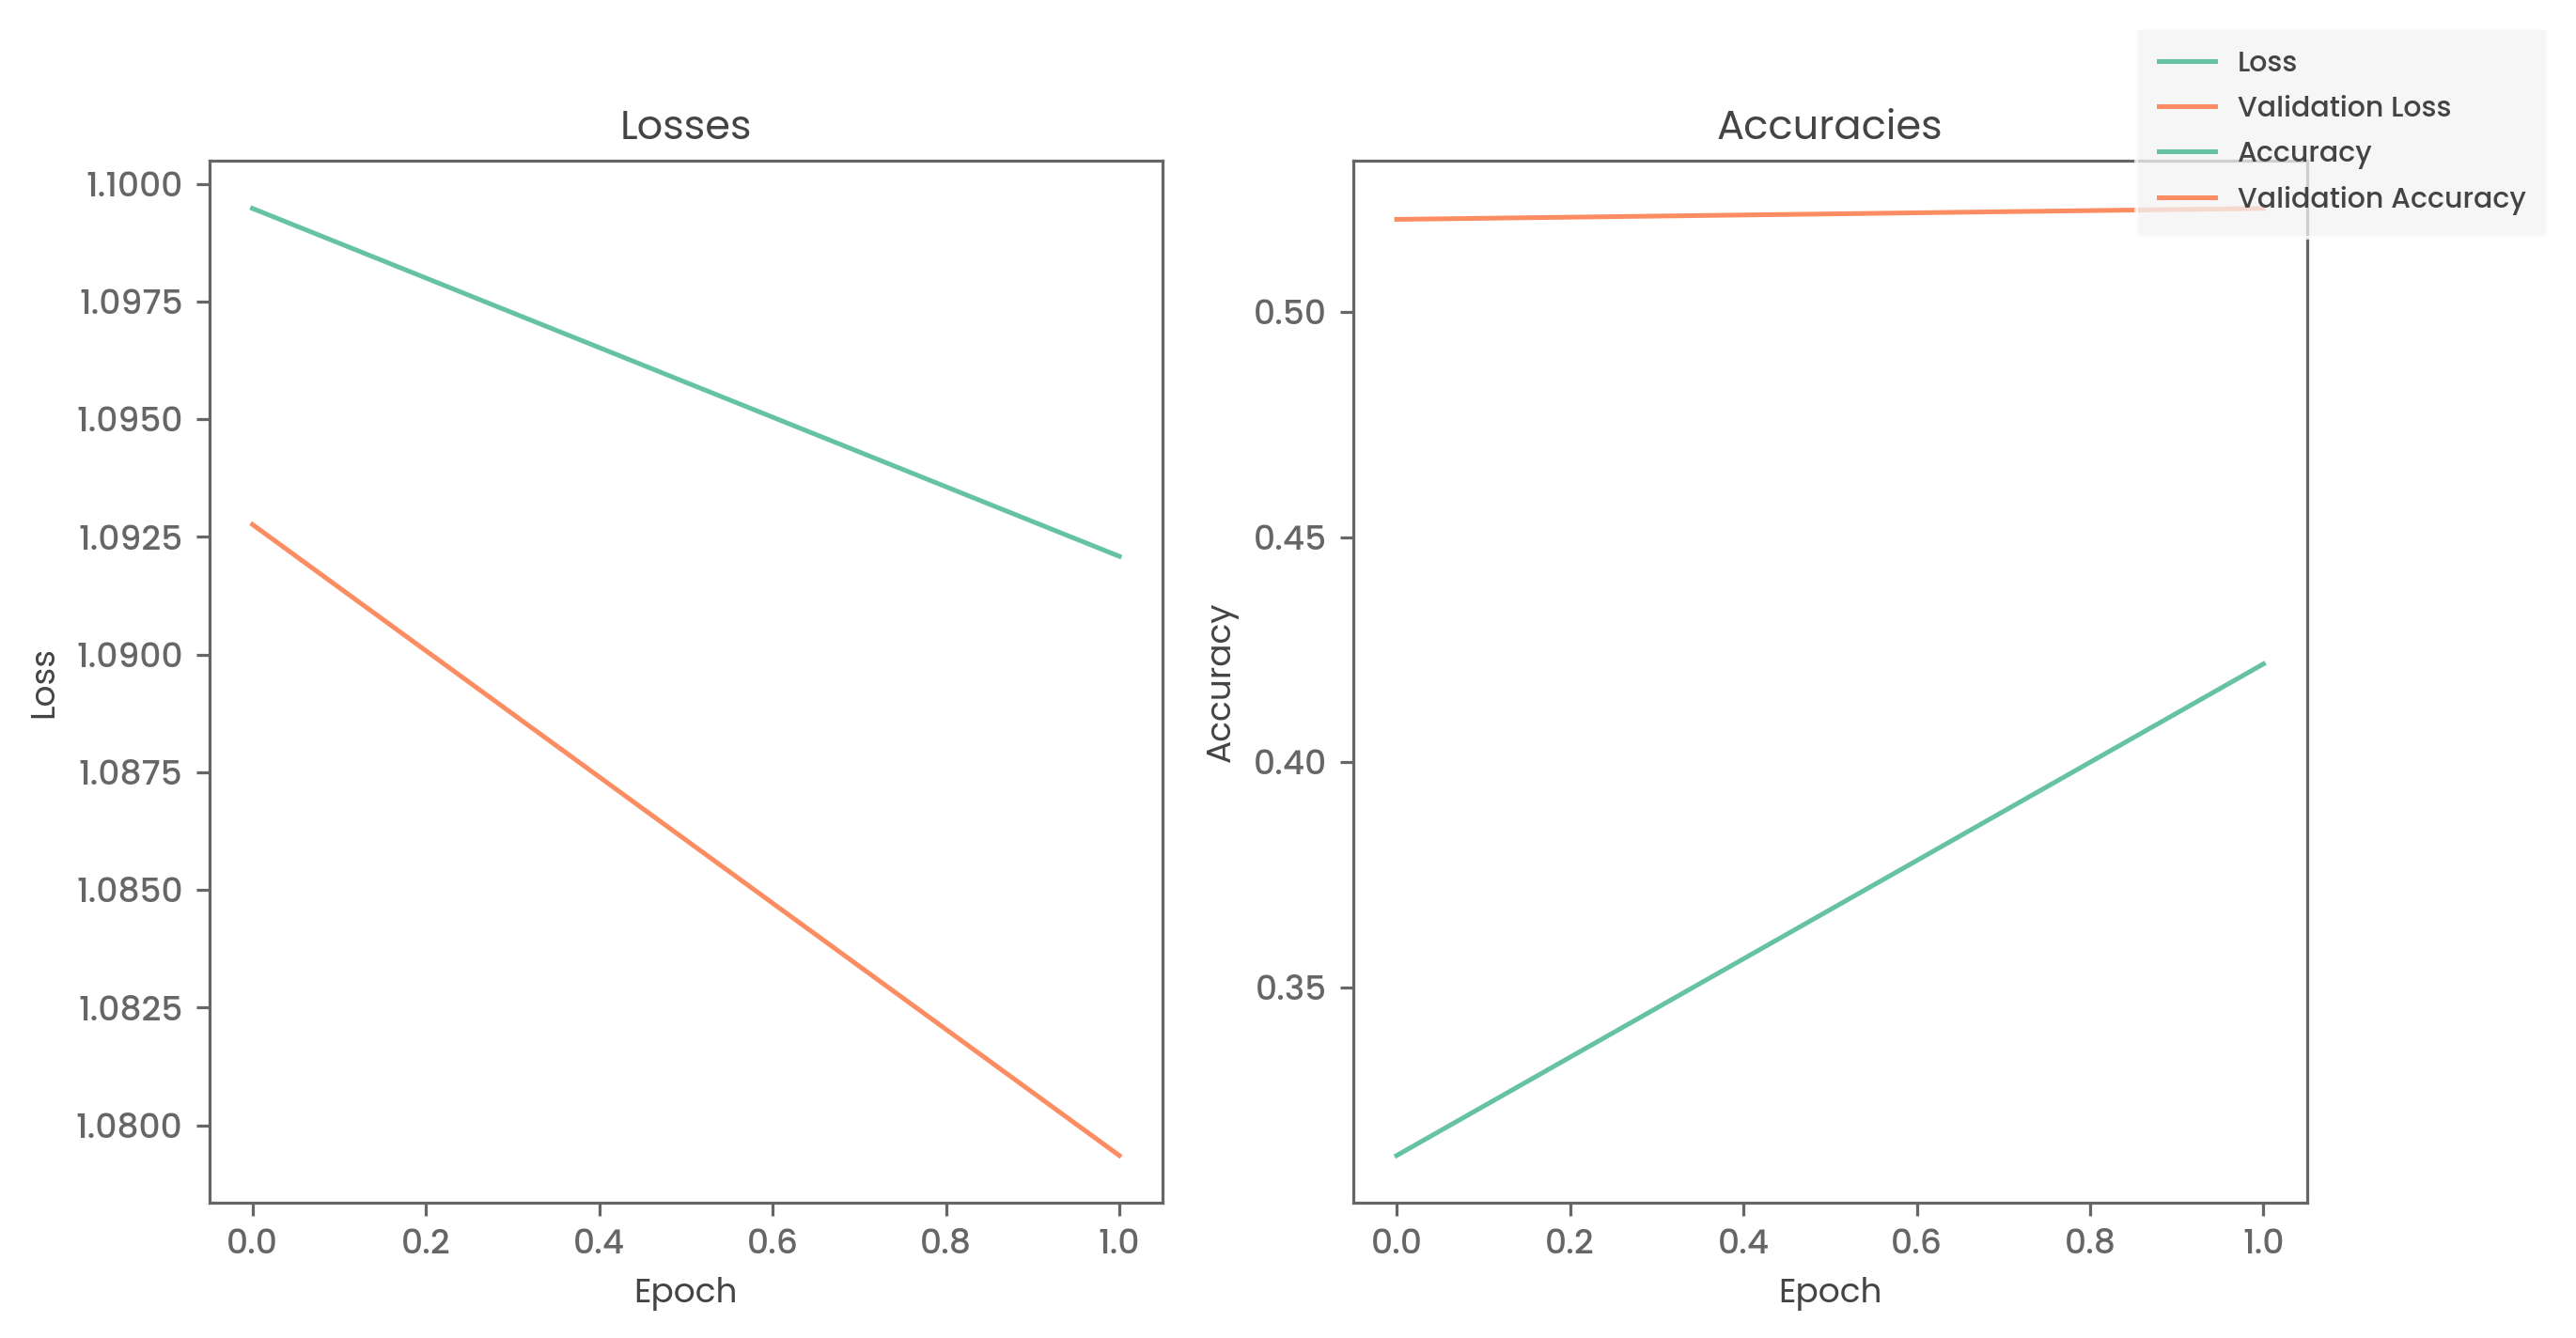

In [133]:
def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    axes[0].plot(h['loss'], label='Loss')
    axes[0].plot(h['val_loss'], label='Validation Loss')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses')

    axes[1].plot(h['accuracy'], label='Accuracy')
    axes[1].plot(h['val_accuracy'], label='Validation Accuracy')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracies')

    fig.legend()

plot_history(hist.history)
hist.history

In [134]:
model.evaluate(test_prep_ds.batch(256))

15/15 [==============================] - 19s 1s/step - loss: 1.0803 - accuracy: 0.5161


[1.0802990198135376, 0.5160788893699646]

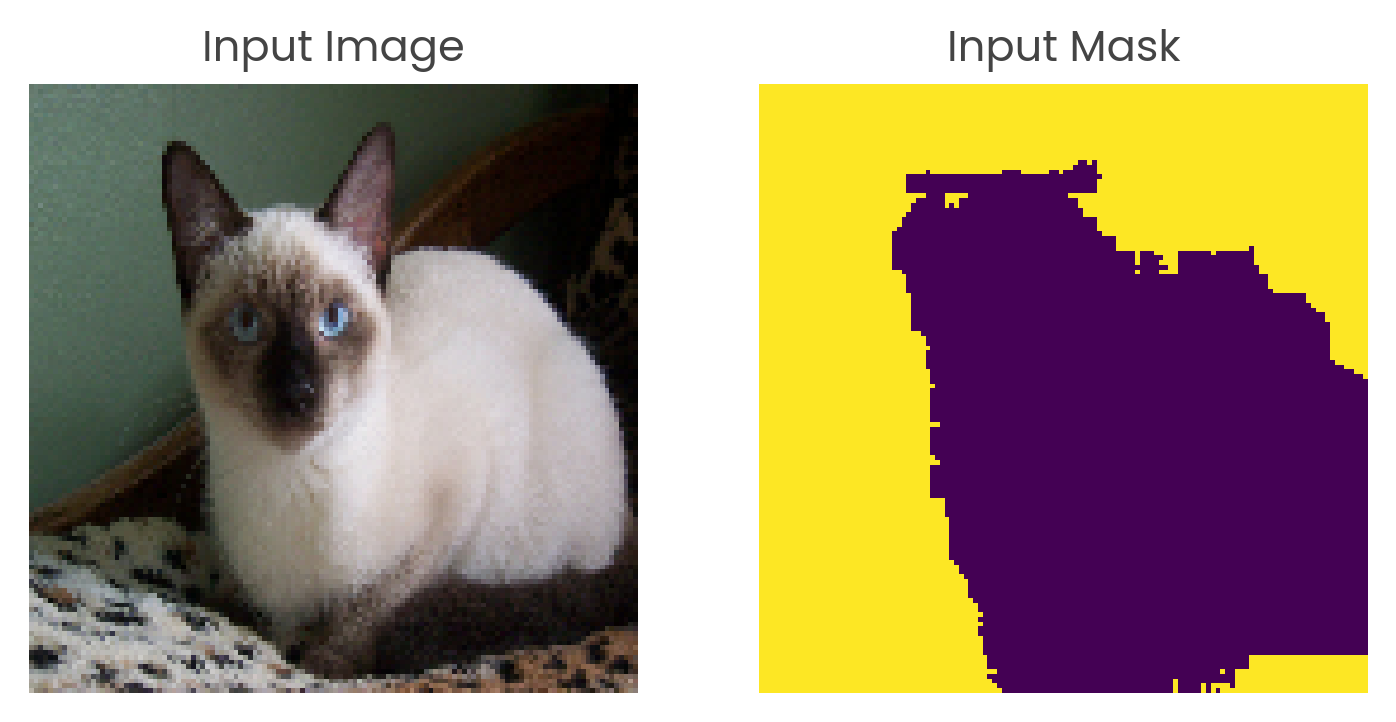

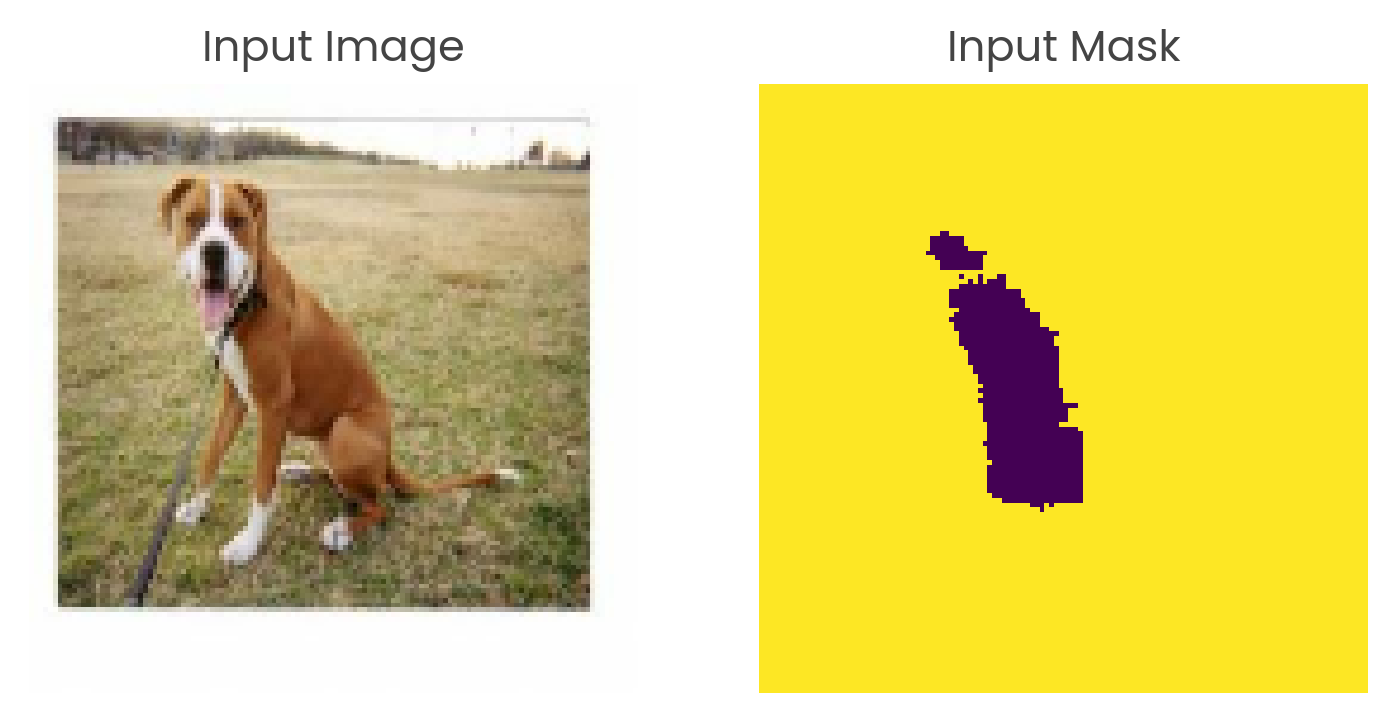

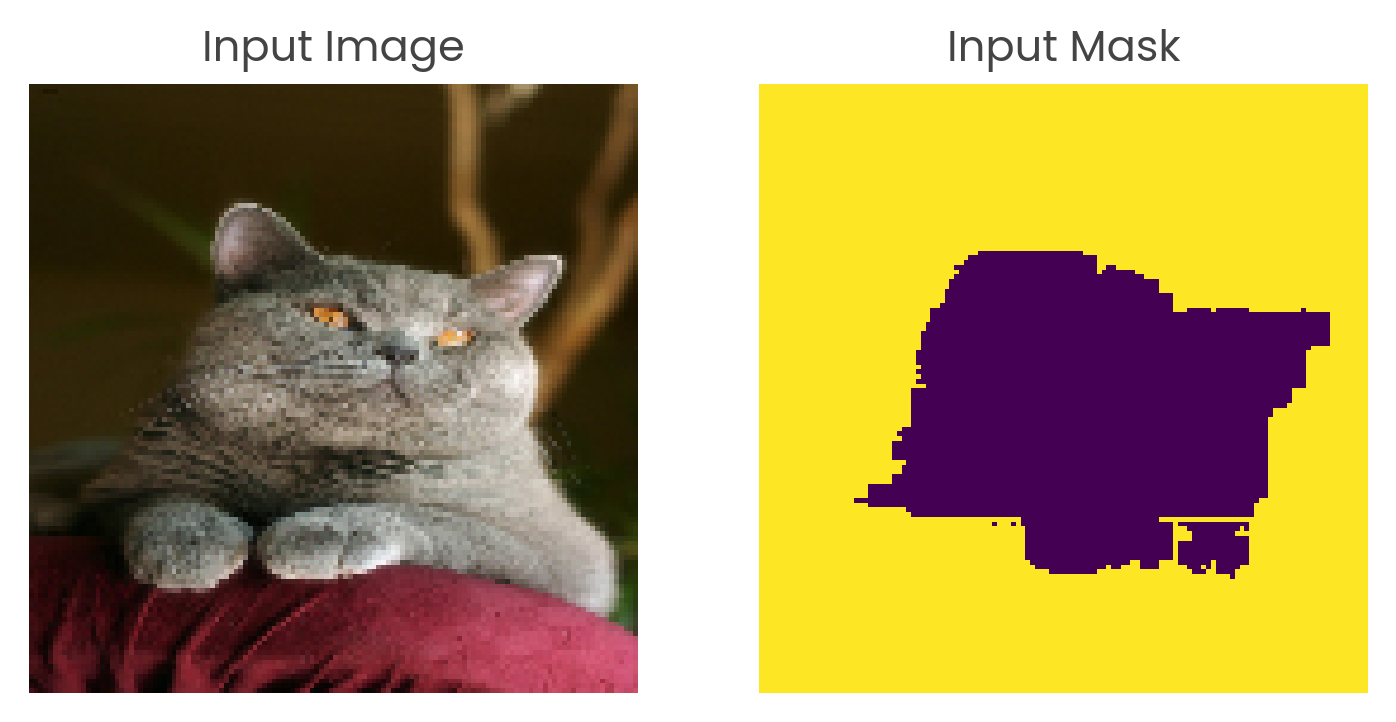

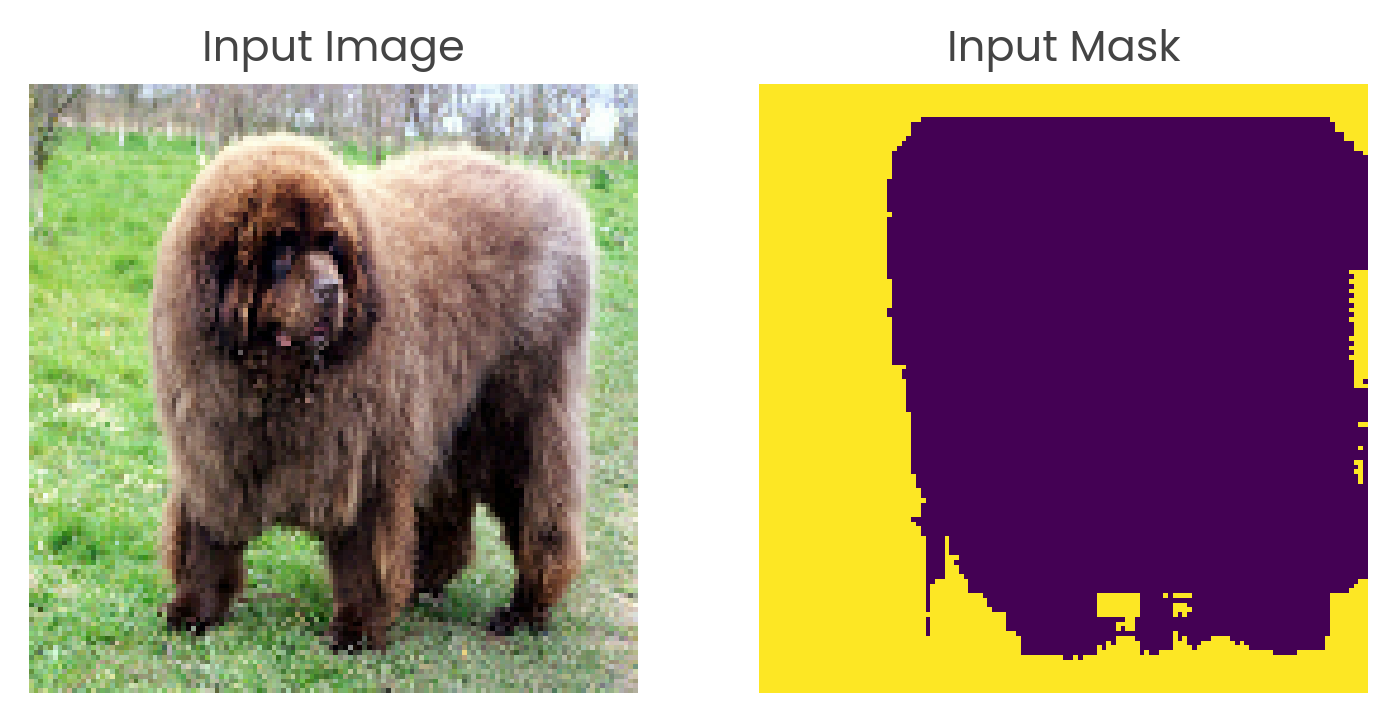

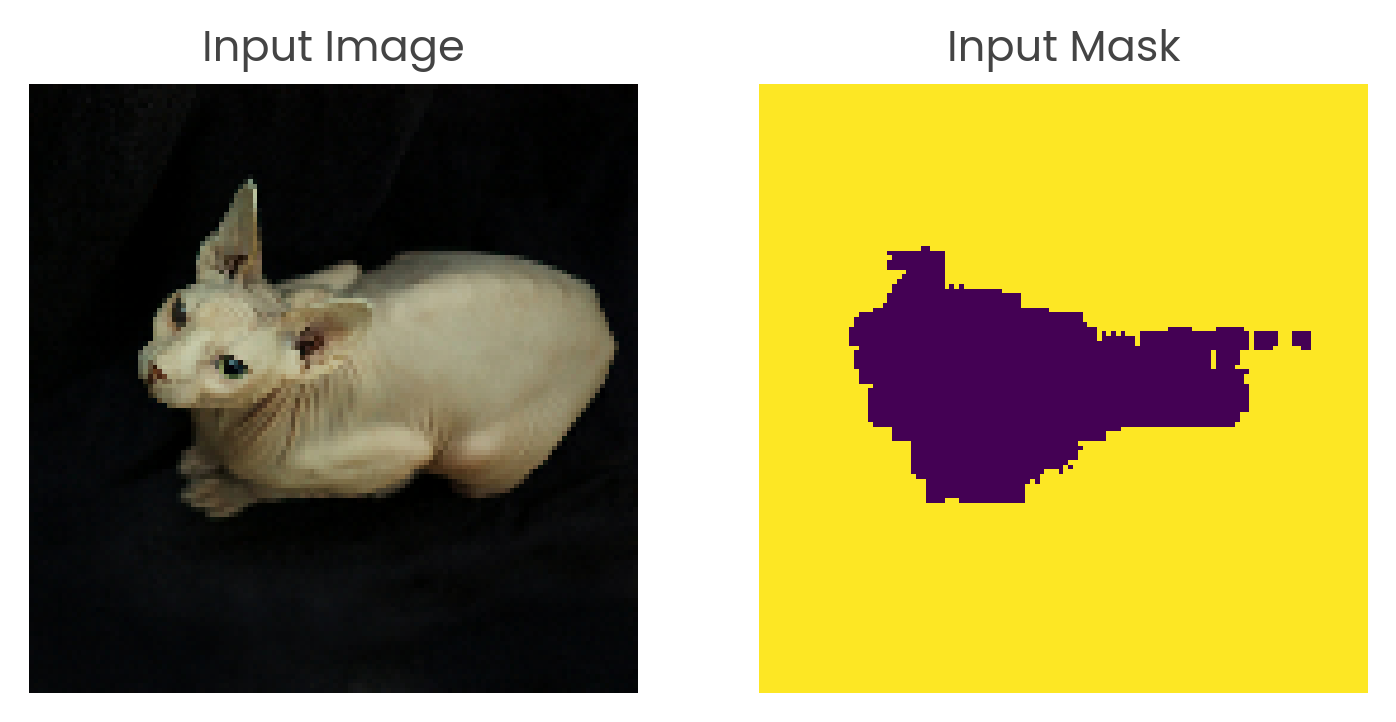

In [194]:
batch = iter(train_prep_ds.shuffle(buffer_size=5).batch(5)).next()
masks = tf.expand_dims(tf.math.argmax(tf.math.softmax(model(batch[0]), axis=-1), axis=-1), axis=-1)

for image, mask in zip(batch[0], masks):
    sample = {'Input Image': image, 'Input Mask': mask}
    plot_grid(sample, cols=2)
# masks.shape